# Load librariers and dataset

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
from bokeh.io import output_notebook
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.charts import BoxPlot, output_file, show
import scipy.stats as stats
import math
from bokeh.charts import Histogram, output_file, show
import networkx as nx
import community
import folium

output_notebook()

Loading BokehJS ...

In [2]:
data = pd.read_pickle('../datasets/df_userID.pickle')
data.columns

Index(['Race', 'Date', 'RaceYear', 'RaceMonth', 'Category', 'Distance', 'Name',
       'Sex', 'Year', 'LivingPlace', 'Rank', 'Time', 'Pace', 'Place',
       'MinTemp', 'MaxTemp', 'Weather', 'RaceID', 'UserID'],
      dtype='object')

# Geographical scraping

In this section  link each provenience city (saved as 'LivingPlace' in the dataset) to its own Canton. We will consider only the major Swiss cities in this analysis. The reader can refer to the following [web page](http://official-swiss-national-languages.all-about-switzerland.info/names-swiss-villages-towns-languages.html). This approximate procedure allows us to map roughly the 40% of the whole dataset, as we will verify. The geographical information is saved in an excel file named 'swisscities.xlsx', whereas the population of each own canton is saved in 'canton_population.xlsx'. 

In [3]:
cities = pd.read_excel('../datasets/swisscities.xlsx')
cities = cities[['Village / Town','Canton']]
cities['City']=cities['Village / Town']
del cities['Village / Town']

In [4]:
cities.head()

,Canton,City
0,TG,Aadorf
1,AG,Aarau
2,BE,Aarberg
3,AG,Aarburg
4,BE,Aarwangen


We extract all the living places in the dataset:

In [5]:
provenience = data.LivingPlace.unique()

Then we map each city to its own Canton, whenever it is possible; otherwise we set the corresponding Canton to 'nan' (null value).

In [6]:
general_mapping = {}
for city in provenience:
    if city in list(cities.City):
        general_mapping[city] = list(cities[cities.City==city].Canton)[0]
    else:
        general_mapping[city]='nan'

In [7]:
canton = []
for i in data.index:
    canton.append(general_mapping[data.loc[i].LivingPlace])
canton = pd.Series(data=canton,index=data.index)
data['LivingCanton']=canton

Finally we save a reduced version of the dataset, which will be slightly faster to manipulate:

In [8]:
geodata = data[data.LivingCanton!='nan']

As we anticipated, the length of the mapped subset of the dataset is around 40%:

In [9]:
len(geodata)/len(data)

0.39492780873864847

Then we count all the occurrencies for any Canton in time and save the results in a suitable dataframe:

In [10]:
cantons_per_year = {}
for year in range(np.min(geodata.RaceYear),np.max(geodata.RaceYear)+1):
    cantons_per_year[year]=geodata[geodata.RaceYear==year].LivingCanton.value_counts()

In [11]:
particip = []
years = range(np.min(geodata.RaceYear),np.max(geodata.RaceYear)+1)
for year in years:
    particip.append(cantons_per_year[year].sum())

In [12]:
cantons = geodata.LivingCanton.unique()
cantons = cantons[cantons!='nan']

In [13]:
time_evolution = pd.DataFrame()
for year in years:
    if 'BE/NE' in cantons_per_year[year].index:
        cantons_per_year[year]['BE']+=cantons_per_year[year]['BE/NE']
    time_evolution[year]=cantons_per_year[year]
cantons = cantons[cantons!='BE/NE']
time_evolution = time_evolution.set_index(cantons)
time_evolution

,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
VS,1308,3332,2965,3964,4626,4600,5535,6121,6697,7260,7146,8229,8534,7713,8108,7570
BE,730,1100,1818,2363,2638,2935,3490,3235,3318,3777,3801,3847,3956,3842,4269,3705
FR,176,757,901,1300,1400,1733,1830,2017,1733,1986,1835,2106,3210,3159,3208,2265
JU,173,1453,1971,4543,4826,4940,6412,6578,6878,7771,5735,6512,7184,6879,7425,4078
AG,170,737,831,1177,635,718,937,1947,1991,2336,2845,3435,4031,4381,4654,4123
VD,158,608,924,1345,1332,1229,1817,1847,2104,3203,3343,3235,3023,3245,3148,2132
SO,145,436,582,980,1208,1939,2070,1841,1951,2058,1500,1590,1502,1464,1501,1096
LU,142,1034,1870,2725,1172,2006,3778,4276,4070,8252,11050,12266,12674,14805,15714,12966
ZG,87,347,325,513,567,605,658,686,788,967,1040,1220,1363,1220,1339,816
NE,76,153,206,216,212,207,278,315,428,535,440,420,371,294,361,266


To observe relative quantities, we need to consider also the overall population of each Canton. We have saved this information in another excel file, named 'canton_population.xslx'. After loading it, we use the *Bokeh* library to plot the results.

In [14]:
# population density per canton
canton_population = pd.read_excel('../datasets/canton_population.xlsx')
canton_population = canton_population[['Canton','Population','Area']]
canton_population = canton_population.set_index('Canton')

# Time evolution: plots

With the following cells some *bokeh* plots are generated to visualize the time evolution of runners occurrencies both in general and by Canton across the years:

In [15]:
p = figure(title = 'Number of participants vs time', plot_width=400, plot_height=400)
p.title.align = "center"
p.title.text_font_size = "16px"
p.xaxis[0].axis_label = 'year'
p.yaxis[0].axis_label = 'runners'
p.xaxis[0].axis_label_text_font_size = '14px'
p.yaxis[0].axis_label_text_font_size = '14px'

# add a circle renderer with a size, color, and alpha
p.line(years, particip, color="navy", line_width=1.5)
p.circle(years, particip, size=10, color="navy", alpha=0.5)

# show the results
show(p)

For the sake of clarity and cleaness of visualization, we report only the most significant Cantons:

In [16]:
colors = ['blue','red','green','orange','navy','chartreuse','darkmagenta','darkgoldenrod','darkslategrey','royalblue']
years = range(2000,2016)

p = figure(title = 'Runners from some Cantons vs time', plot_width=600, plot_height=600)
p.title.align = "center"
p.title.text_font_size = "18px"
p.xaxis[0].axis_label = 'year'
p.yaxis[0].axis_label = 'runners'
p.xaxis[0].axis_label_text_font_size = '16px'
p.yaxis[0].axis_label_text_font_size = '16px'
subindex = ['SO','BE','VD','VS','ZH','GE','TI','FR']
for k in range(len(subindex)):
    i = subindex[k]
    p.line(years, time_evolution.loc[i], legend = i, color=colors[k], line_width=2)
    p.circle(years, time_evolution.loc[i], size=7, color=colors[k])
p.legend.location = "top_left"
p.legend.label_text_font_size = '16px'
show(p)

In the following plot the population-normalized amount of runners is shown:

In [17]:
p2 = figure(title = 'Ratio runners / Canton population vs time', plot_width=600, plot_height=600)
p2.title.align = "center"
p2.title.text_font_size = "18px"
p2.xaxis[0].axis_label = 'year'
p2.yaxis[0].axis_label = 'runners/population'
p2.xaxis[0].axis_label_text_font_size = '16px'
p2.yaxis[0].axis_label_text_font_size = '16px'
subindex = ['JU','SO','VD','VS','FR','BE','GE','ZH']
for k in range(len(subindex)):
    i = subindex[k]
    p2.line(years, time_evolution.loc[i]/canton_population.loc[i].Population, legend = i, color=colors[k], line_width=2)
    p2.circle(years, time_evolution.loc[i]/canton_population.loc[i].Population, size=7, color=colors[k])
p2.legend.location = "top_left"
p2.legend.label_text_font_size = '16px'
# show the results
show(p2)

The plots show that the global increasing trend of people participation can be observed also with respect to the Swiss Cantons taken singularly, which is coherent with the expectations.

# A qualitative visualization approach

We are now interested in possible geographical analogies or differences among Swiss Cantons in terms of the 'Time' feature, which may be assumed as a good indicator of the runner's performance. For the sake of simplicity and computational affordability, we will restrict our analysis to the Marathon only, but by changing few lines of code one can extend easily the analysis to other competitions by changing the distance parameter (see below). 

In order to achieve this goal, we will perform cross Kolmogorov-Smirnov (KS) tests to validate significant differences among the cantonal distributions (here the year variable is neglected). To translate this cross checks into a readable information, we will interpret the p-values dataframe as an adjacency matrix of a graph, whose nodes represent the Cantons and where the edge between node $i$ and node $j$ exists when their cross test p-value is above a fixed threshold (5%).

Thereafter, we will apply the [Louvain algorithm](https://en.wikipedia.org/wiki/Louvain_Modularity) (based on the concept of modularity) to identify hidden communities. The possible meaning of a community is related to geographical similarities among cantonal distributions, as we will verify later. We will also perform an essential sensitivity analysis of the community detection with respect to the p-value threshold. As a final check, we will treat each community as a whole population and will perform again the KS test on the macrocantons.

To visualize the communities, we will upload a suitable choropleth map where any color stands for a single community.

# Female Marathon

Here we focus on the female runners competing in the Marathons (42 km) and compare their times splitting them into groups per Canton. We work on a subset of the mapped dataframe.

In [18]:
df = geodata[(geodata.Sex=='F') &  (geodata.Distance>=41.0) & (geodata.Distance<=43.0)]
df.Time = df.Time.apply(lambda x: x.total_seconds()/60) # display time in minutes
cantons = geodata.LivingCanton.unique()
cantons = cantons[cantons!='nan']

C:\Users\Utente\Anaconda3\lib\site-packages\pandas\core\generic.py:2701: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


Cantonal differences:

In [19]:
agg = df[['Time','LivingCanton']]
agg = agg.rename(columns={'Time':'mean time [minutes]','LivingCanton':'Canton'})
p = BoxPlot(agg, values='mean time [minutes]', label='Canton', outliers=False,legend=False,
            color='cornflowerblue',title='mean time boxplot for female marathon (42 km)')
p.title.align = "center"
p.title.text_font_size = "18px"
p.xaxis[0].axis_label = 'Canton'
p.yaxis[0].axis_label = 'mean time [minutes]'
p.xaxis[0].axis_label_text_font_size = '16px'
p.yaxis[0].axis_label_text_font_size = '16px'

show(p)

To justify the usage of non-parametric tests, we verify that the normality hypothesis does not hold. In particular we will display the *heteroschedasticity plot* (dispersion of residuals around the expected value 0) and compute the p-value of the related [Shapiro-Wilk](https://en.wikipedia.org/wiki/Shapiro%E2%80%93Wilk_test) test. As anticipated, we will apply the [Kolmogorov-Smirnov]() test to test the null hypothesis that two cantonal samples are drawn from the same distribution. We will exploit the *scipy* library to do that.

In the following we define the samples per Cantonal division and compute the KS test p-values for all the pairs of Cantons, reporting the results in a dataframe. We proceed in this way because for multiple samples the KS test provides an answer for the existence of one arbitrary sample with a different mean with respect to the overall population, without identifying it. In some separate cells we take a look at the distribution of one arbitrary sample and compare it to a Gaussian, in order to verify if the normality hypothesis is valid (in which case we could use an ANOVA procedure).

In [20]:
samples = []
for k in cantons:
    samples.append(df.Time[df.LivingCanton==k])

In [22]:
Nc = 10
sample = samples[Nc]
p = figure(title = 'Heteroschedasticity for time variable, Canton '+str(cantons[Nc]), plot_width=500, plot_height=500)
p.title.align = "center"
p.title.text_font_size = "18px"
p.xaxis[0].axis_label = 'index'
p.yaxis[0].axis_label = 'residuals [minutes]'
p.xaxis[0].axis_label_text_font_size = '16px'
p.yaxis[0].axis_label_text_font_size = '16px'

p.line(x=[0,len(sample)],y=[0,0],line_width=2,line_dash=[3,3],color='red')
p.circle(range(0,len(sample)), sample-np.mean(sample), size=5, color="navy", alpha=0.5)

show(p)

In particular here we compute the p-value of the Shapiro-Wilk test for normality:

In [23]:
Nc = 10
sample = samples[Nc]
stats.shapiro(sample)

(0.9078530073165894, 9.193130176876967e-30)

Given the exremely small value, we can assume distributions are not normal. In the following plot we display the histogram:

In [24]:
# normality hypothesis: Gaussian distribution, Shapiro-Wilk test
df2 = pd.DataFrame({'time':sample})
p = Histogram(df2,values='time',color='navy',bins=30,
              title='Time PDF for Canton ' +str(cantons[Nc]),
              density=True,legend='top_right')
p.title.align = "center"
p.title.text_font_size = "18px"
p.xaxis[0].axis_label = 'time [minutes]'
p.yaxis[0].axis_label = 'density'
p.xaxis[0].axis_label_text_font_size = '16px'
p.yaxis[0].axis_label_text_font_size = '16px'
m = np.mean(sample)
sigma = np.std(sample)
def gaussian(y,m,sigma):
    return 1/math.sqrt(2*math.pi*sigma*sigma)*math.exp(-(y-m)*(y-m)/2/(sigma*sigma))
yy = np.arange(np.min(sample), np.max(sample), 0.1)
gg = []
for k in range(len(yy)):
    gg.append(gaussian(yy[k],m,sigma))
p.line(list(yy),gg,line_width=2,color='red',legend='Gaussian')

show(p)

Now we perform the crossed KS tests and report the p-values in a dataframe:

In [25]:
cantons

array(['VS', 'BE', 'FR', 'JU', 'AG', 'VD', 'SO', 'LU', 'ZG', 'NE', 'ZH',
       'BL', 'TG', 'BS', 'TI', 'GE', 'GR', 'SH', 'AR', 'SG', 'AI', 'UR',
       'SZ', 'GL', 'NW', 'OW'], dtype=object)

In [26]:
p_values = {}
for i in range(len(cantons)):
    for j in range(i,len(cantons)):
        p_values[(i,j)]=stats.ks_2samp(samples[i],samples[j])[1]

In [27]:
P_VALUES = pd.DataFrame()
for j in range(len(cantons)):
    col = []
    for i in range(0,j):
        p = p_values[(i,j)]
        col.append(p)
    col.append(1.0)
    for i in range(j+1,len(cantons)):
        p = p_values[(j,i)]
        col.append(p)
    col = pd.Series(data=col,index=cantons)
    P_VALUES[cantons[j]]=col

We report a subset of the dataframe for visualization purposes only:

In [28]:
P_VALUES[['VS','BE','VD','ZH']].loc[['VS','BE','VD','ZH']]

,VS,BE,VD,ZH
VS,1.000000e+00,8.155667e-01,3.803167e-02,4.333529e-08
BE,8.155667e-01,1.000000e+00,3.513220e-07,1.405954e-64
VD,3.803167e-02,3.513220e-07,1.000000e+00,9.659029e-08
ZH,4.333529e-08,1.405954e-64,9.659029e-08,1.000000e+00


Now we set a threshold $\alpha=5\%$ to mark all the significant p-values in the dataframe. This operation will allow us to observe which are the statistically significant differences among Cantons:

In [29]:
alpha = 0.05
for k in P_VALUES.columns:
    P_VALUES[k] = P_VALUES[k].apply(lambda y: (y<0.05))

In [30]:
P_VALUES[['VS','BE','VD','ZH','FR','TI']].loc[['VS','BE','VD','ZH','FR','TI']]

,VS,BE,VD,ZH,FR,TI
VS,False,False,True,True,False,True
BE,False,False,True,True,True,True
VD,True,True,False,True,False,True
ZH,True,True,True,False,True,False
FR,False,True,False,True,False,False
TI,True,True,True,False,False,False


To turn these statistical interactions into a visual object, we transform the dataframe into a graph object, whose nodes represent the cantons and whose edges stand for the 'False' entry (that is, the KS cannot provide evidence for the two Cantons to have different distributions). We use the *graph_tool* library to deal with such an instance:

In [31]:
positions = {}
positions['SH']=(0,0)
positions['ZH']=(0,-1)
positions['TG']=(1,-1)
positions['AG']=(-1,-1)
positions['BL']=(-2,-0.5)
positions['BS']=(-3,-0.5)
positions['SO']=(-2,-1.5)
positions['JU']=(-4,-1.5)
positions['SG']=(1,-3)
positions['AR']=(3.5,-2.5)
positions['AI']=(3.5,-3.5)
positions['GL']=(2.5,-3)
positions['SZ']=(0,-2.5)
positions['ZG']=(-1,-2.5)
positions['LU']=(-2,-2.5)
positions['NE']=(-4,-3)
positions['VD']=(-5,-4)
positions['GE']=(-6,-5)
positions['FR']=(-3,-4)
positions['BE']=(-2,-4)
positions['OW']=(-1,-4)
positions['NW']=(-0,-4)
positions['UR']=(1,-4)
positions['GR']=(3,-6)
positions['VS']=(-3,-5)
positions['TI']=(-1,-7)

In [32]:
G = nx.Graph()
cantons = list(cantons)
for i in range(len(cantons)):
    G.add_node(cantons[i],pos=positions[cantons[i]])
for i in range(len(cantons)):
    for j in range(i+1,len(cantons)):
        if P_VALUES[cantons[i]].loc[cantons[j]]==False:
            G.add_edge(cantons[i],cantons[j])

We visualize now the graph in a geometrical fashion:

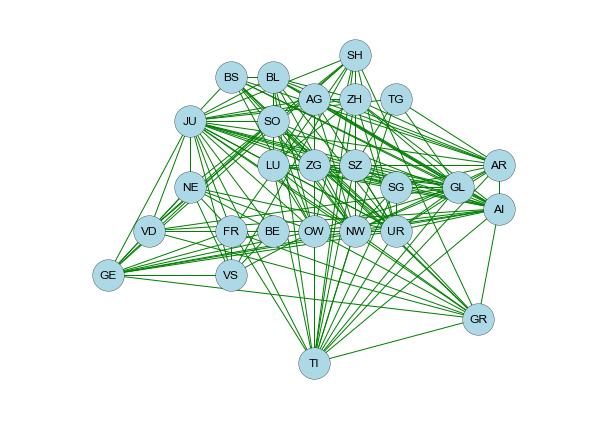

In [33]:
pos=nx.get_node_attributes(G,'pos')
nx.draw(G,pos,node_color='lightblue',node_size=1000,with_labels=True,edge_color='green')

Since we want to bring out possible communities within the graph, we apply the modularity-based *Louvain algorithm* (see [here](https://en.wikipedia.org/wiki/Louvain_Modularity) for references), as we want to discover subsets of the graph which are "well" interconnected, rather than determine a hierarchical structure (for which the *Girvan-Newman* algorithm would be fine, [here](https://en.wikipedia.org/wiki/Girvan%E2%80%93Newman_algorithm) for references). We define the optimal graph partition within communities and compute its modularity measure.

Community 0
['UR', 'ZH', 'GL', 'BL', 'ZG', 'SZ', 'TI', 'TG', 'NW', 'SG', 'BS', 'AR', 'LU', 'AG', 'AI']
Community 1
['GE', 'BE', 'SH', 'VS', 'FR', 'NE', 'SO', 'JU', 'VD', 'OW', 'GR']


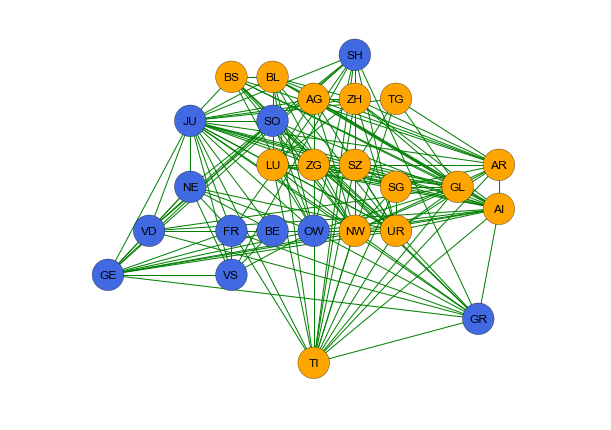

Modularity score: 0.19453100381639304


In [34]:
partition = community.best_partition(G)

for i in set(partition.values()):
    print ("Community", i)
    members = list_nodes = [nodes for nodes in partition.keys() if partition[nodes] == i]
    print (members)

values = [partition.get(node) for node in G.nodes()]
colors = {0 : 'orange', 1 : 'royalblue'}
cols = []
for i in range(len(values)):
    cols.append(colors[values[i]])
nx.draw(G, pos,cmap = plt.get_cmap('brg'), node_color = cols, node_size=1000, with_labels=True,edge_color='green')
plt.show()

print ("Modularity score:", community.modularity(partition, G))

The modularity measure is not very high (>0.3), which means that the two components are not much more connected than expected (in terms of the modularity approach). To observe if this clustering is meaningful or not, we recompute the bokeh boxplots with this peculiar partition and observe what it happens:

In [38]:
agg = df[['Time','LivingCanton']]
communities = agg.LivingCanton.apply(lambda x: partition[x])
agg['community']=communities
agg = agg.rename(columns={'Time':'mean time [minutes]','LivingCanton':'Canton'})
p = BoxPlot(agg, values='mean time [minutes]', label='Canton', outliers=False,legend=False,
            color='community',title='mean time boxplot for female marathon (42 km)')
p.title.align = "center"
p.title.text_font_size = "18px"
p.xaxis[0].axis_label = 'Canton'
p.yaxis[0].axis_label = 'mean time [minutes]'
p.xaxis[0].axis_label_text_font_size = '16px'
p.yaxis[0].axis_label_text_font_size = '16px'

show(p)

C:\Users\Utente\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


Although the modularity measure is not very high, the graph partition seems to catch the difference between two populations, one "faster" than the other. This is quite interesting, as the statistical method we used brings out little geographical differences in the runners performance, as far as the female marathons are concerned. Our last step is then to visualize this difference with a choropleth map:

In [39]:
zone = []
for c in cantons:
    zone.append(1-partition[c])
geopartition = pd.DataFrame({'canton' : cantons, 'zone' : zone})
geopartition.head()

,canton,zone
0,VS,0
1,BE,0
2,FR,0
3,JU,0
4,AG,1


In the following map the darkest color stands for the "faster" runners, whereas the lightest one for the "slower" runners. There is a clear geographical separation between the two regions, which is actually surprising:

In [40]:
np.array(geopartition[geopartition.zone==1].canton)

array(['AG', 'LU', 'ZG', 'ZH', 'BL', 'TG', 'BS', 'TI', 'AR', 'SG', 'AI',
       'UR', 'SZ', 'GL', 'NW'], dtype=object)

In [41]:
map_geopart = folium.Map(location=[46.8, 8],zoom_start=8)
state_geo = r'ch-cantons.topojson.json'
map_geopart.choropleth(geo_path=state_geo,key_on='feature.id',topojson='objects.cantons',data=geopartition,
                   columns=['canton','zone'],fill_color='YlGn', fill_opacity=0.7, line_opacity=0.2,
                  legend_name='Geographical zone',
                  threshold_scale=[0,0.5,1])
map_geopart

To validate this result, we interpret now this communities as "macrocantons", each one endowed with its own statistical distribution. The samples here will thus be defined not by their Canton, but by their community index. We are going now to plot the macro-boxplots and perform a macroscopic KS-test:

In [63]:
p = Histogram(agg, values='mean time [minutes]', label='community',legend=True,
            color='community',title='Community-based histograms (female 42 km)')
p.title.align = "center"
p.title.text_font_size = "18px"
p.xaxis[0].axis_label = 'Community'
p.yaxis[0].axis_label = 'mean time [minutes]'
p.xaxis[0].axis_label_text_font_size = '16px'
p.yaxis[0].axis_label_text_font_size = '16px'

show(p)

In [49]:
comm = agg.community.unique()
samples = []
for k in comm:
    samples.append(agg['mean time [minutes]'][agg.community==k])

In [54]:
p_values = {}
for i in range(len(comm)):
    for j in range(i,len(comm)):
        p_values[(i,j)]=stats.ks_2samp(samples[i],samples[j])[1]

In [55]:
P_VALUES = pd.DataFrame()
for j in range(len(comm)):
    col = []
    for i in range(0,j):
        p = p_values[(i,j)]
        col.append(p)
    col.append(1.0)
    for i in range(j+1,len(comm)):
        p = p_values[(j,i)]
        col.append(p)
    col = pd.Series(data=col,index=comm)
    P_VALUES[comm[j]]=col
P_VALUES

,1,0
1,1.000000e+00,1.118723e-81
0,1.118723e-81,1.000000e+00


The KS test tracks a remarkable difference in the two distributions. According to this procedure, we can then conclude that the existence of two distinct distributions in the race time may be linked to certain geographical patterns. We remark that this result is influenced by the chosen non-parametric test (KS), by the selection of a threshold (which will be examined in the following section) and by the not so strong modularity of the associated graph. We think this result may be interesting in the extent it reflects a possible variegate composition of runners in terms of geographical features.

## Sensitivity analysis

We remark that our qualitative analysis (geoscraping, KS test for Cantonal distributions, graph construction) may be sensitive to the $\alpha=5\%$ threshold we have used to define 'interactions', intended as the impossibility to reject the null hypothesis of equal distributions. In this section we let vary the threshold among usual values (1-10%) in order to evaluate how much this analysis can be distorted by this choice. We will consider only the effect of the graph construction, without visualizing it with a choropleth map, for the sake of brevity.

In [57]:
samples = []
for k in cantons:
    samples.append(df.Time[df.LivingCanton==k])

In [58]:
p_values = {}
for i in range(len(cantons)):
    for j in range(i,len(cantons)):
        p_values[(i,j)]=stats.ks_2samp(samples[i],samples[j])[1]

In [59]:
# generate a list of dataframes, each one associated to a certain statistical threshold
alpha = [0.1,0.025,0.01]
P_VALUES = []
for k in range(len(alpha)):
    pv = pd.DataFrame()
    for j in range(len(cantons)):
        col = []
        for i in range(0,j):
            p = p_values[(i,j)]
            col.append(p)
        col.append(1.0)
        for i in range(j+1,len(cantons)):
            p = p_values[(j,i)]
            col.append(p)
        col = pd.Series(data=col,index=cantons)
        pv[cantons[j]]=col
    P_VALUES.append(pv)

In [60]:
for k in range(len(alpha)):
    for q in P_VALUES[k].columns:
        P_VALUES[k][q] = P_VALUES[k][q].apply(lambda y: (y<alpha[k]))

In [61]:
GRAPHS = []
for k in range(len(alpha)):
    G = nx.Graph()
    cantons = list(cantons)
    for i in range(len(cantons)):
        G.add_node(cantons[i],pos=positions[cantons[i]])
    for i in range(len(cantons)):
        for j in range(i+1,len(cantons)):
            if P_VALUES[k][cantons[i]].loc[cantons[j]]==False:
                G.add_edge(cantons[i],cantons[j])
    GRAPHS.append(G)

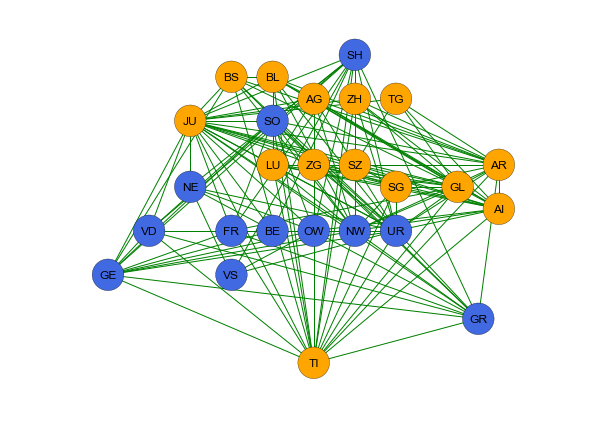

alpha: 0.1
Modularity score: 0.20668054110301765


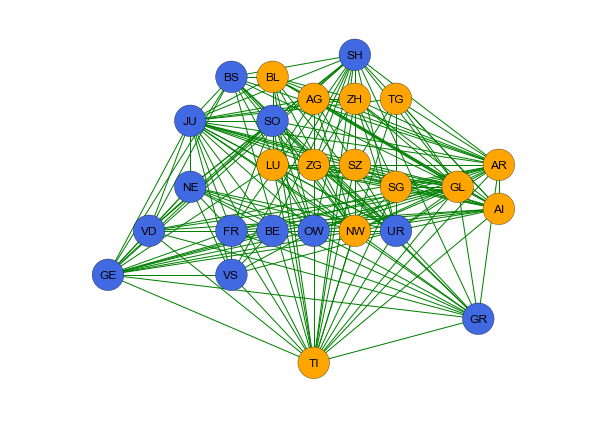

alpha: 0.025
Modularity score: 0.15666691418529244


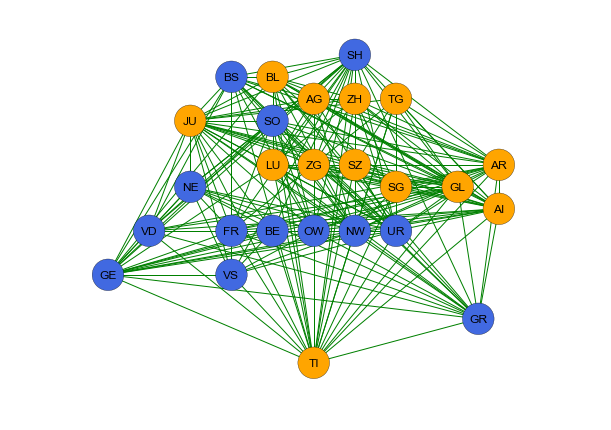

alpha: 0.01
Modularity score: 0.11710697183670155


In [73]:
for k in range(len(alpha)):
    partition = community.best_partition(GRAPHS[k])

    for i in set(partition.values()):
        members = list_nodes = [nodes for nodes in partition.keys() if partition[nodes] == i]

    values = [partition.get(node) for node in GRAPHS[k].nodes()]
    colors = {0 : 'orange', 1 : 'royalblue', 2 : 'violet', 3 : 'lightgreen'}
    cols = []
    for i in range(len(values)):
        cols.append(colors[values[i]])
    nx.draw(GRAPHS[k], pos,cmap = plt.get_cmap('brg'), node_color = cols, node_size=1000, with_labels=True,edge_color='green')
    plt.show()
    print('alpha:',alpha[k])
    print ("Modularity score:", community.modularity(partition, GRAPHS[k]))

We notice that the modularity score decreases with decreasing the threshold $\alpha$, which means that the isolated graph components are less significantly connected in terms of modularity as we impose a more severe bound (that is, more dataframe components turn into 'False', which imposes an edge). This translates into  uncertainty for some nodes of the graph (for example Basel-Stadt, Jura or Nidwalden), which pass from one community to another. However, the two main components preserve their general structure, so that we can conclude our procedure is acceptably robust to little threshold variations.

# Male Marathon

Here we focus on the female runners competing in the Marathons (42 km) and compare their times splitting them into groups per Canton. We work on a subset of the mapped dataframe. The procedure is exactly the same as before.

In [64]:
df = geodata[(geodata.Sex=='M') &  (geodata.Distance>=41.0) & (geodata.Distance<=43.0)]
df.Time = df.Time.apply(lambda x: x.total_seconds()/60) # display time in minutes

C:\Users\Utente\Anaconda3\lib\site-packages\pandas\core\generic.py:2701: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


Cantonal differences:

In [65]:
agg = df[['Time','LivingCanton']]
agg = agg.rename(columns={'Time':'mean time [minutes]','LivingCanton':'Canton'})
p = BoxPlot(agg, values='mean time [minutes]', label='Canton', outliers=False,legend=False,
            color='cornflowerblue',title='mean time boxplot for male marathon (42 km)')
p.title.align = "center"
p.title.text_font_size = "18px"
p.xaxis[0].axis_label = 'Canton'
p.yaxis[0].axis_label = 'mean time [minutes]'
p.xaxis[0].axis_label_text_font_size = '16px'
p.yaxis[0].axis_label_text_font_size = '16px'

show(p)

In [66]:
samples = []
for k in cantons:
    samples.append(df.Time[df.LivingCanton==k])

In [68]:
Nc = 10
sample = samples[Nc]
p = figure(title = 'Heteroschedasticity for time variable, Canton '+str(cantons[Nc]), plot_width=500, plot_height=500)
p.title.align = "center"
p.title.text_font_size = "18px"
p.xaxis[0].axis_label = 'index'
p.yaxis[0].axis_label = 'residuals [minutes]'
p.xaxis[0].axis_label_text_font_size = '16px'
p.yaxis[0].axis_label_text_font_size = '16px'

p.line(x=[0,len(sample)],y=[0,0],line_width=2,line_dash=[3,3],color='red')
p.circle(range(0,len(sample)), sample-np.mean(sample), size=5, color="navy", alpha=0.5)

show(p)

Compute the p-value of the Shapiro-Wilk test for normality:

In [69]:
Nc = 10
sample = samples[Nc]
stats.shapiro(sample)

C:\Users\Utente\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1329: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


(0.9425606727600098, 0.0)

In [70]:
df2 = pd.DataFrame({'time':sample})
p = Histogram(df2,values='time',color='navy',bins=30,
              title='Time PDF for Canton ' +str(cantons[Nc]),
              density=True,legend='top_right')
p.title.align = "center"
p.title.text_font_size = "18px"
p.xaxis[0].axis_label = 'time [minutes]'
p.yaxis[0].axis_label = 'density'
p.xaxis[0].axis_label_text_font_size = '16px'
p.yaxis[0].axis_label_text_font_size = '16px'
m = np.mean(sample)
sigma = np.std(sample)
def gaussian(y,m,sigma):
    return 1/math.sqrt(2*math.pi*sigma*sigma)*math.exp(-(y-m)*(y-m)/2/(sigma*sigma))
yy = np.arange(np.min(sample), np.max(sample), 0.1)
gg = []
for k in range(len(yy)):
    gg.append(gaussian(yy[k],m,sigma))
p.line(list(yy),gg,line_width=2,color='red',legend='Gaussian')

show(p)

Now we perform the crossed KS tests and report the p-values in a dataframe:

In [71]:
p_values = {}
for i in range(len(cantons)):
    for j in range(i,len(cantons)):
        p_values[(i,j)]=stats.ks_2samp(samples[i],samples[j])[1]

In [72]:
P_VALUES = pd.DataFrame()
for j in range(len(cantons)):
    col = []
    for i in range(0,j):
        p = p_values[(i,j)]
        col.append(p)
    col.append(1.0)
    for i in range(j+1,len(cantons)):
        p = p_values[(j,i)]
        col.append(p)
    col = pd.Series(data=col,index=cantons)
    P_VALUES[cantons[j]]=col

We report a subset of the dataframe for visualization purposes only:

In [73]:
P_VALUES[['VS','BE','VD','ZH']].loc[['VS','BE','VD','ZH']]

,VS,BE,VD,ZH
VS,1.000000e+00,7.780417e-05,4.242553e-15,2.472563e-28
BE,7.780417e-05,1.000000e+00,9.169921e-72,5.435501e-232
VD,4.242553e-15,9.169921e-72,1.000000e+00,2.270884e-11
ZH,2.472563e-28,5.435501e-232,2.270884e-11,1.000000e+00


Now we set a threshold alpha = 0.05 to mark all the significant p-values in the dataframe. This operation will allow us to observe which are the statistically significant differences among Cantons:

In [74]:
alpha = 0.05
for k in P_VALUES.columns:
    P_VALUES[k] = P_VALUES[k].apply(lambda y: (y<0.05))

In [75]:
P_VALUES[['VS','BE','VD','ZH','FR','TI']].loc[['VS','BE','VD','ZH','FR','TI']]

,VS,BE,VD,ZH,FR,TI
VS,False,True,True,True,True,True
BE,True,False,True,True,True,True
VD,True,True,False,True,True,True
ZH,True,True,True,False,True,True
FR,True,True,True,True,False,False
TI,True,True,True,True,False,False


In [76]:
positions = {}
positions['SH']=(0,0)
positions['ZH']=(0,-1)
positions['TG']=(1,-1)
positions['AG']=(-1,-1)
positions['BL']=(-2,-0.5)
positions['BS']=(-3,-0.5)
positions['SO']=(-2,-1.5)
positions['JU']=(-4,-1.5)
positions['SG']=(1,-3)
positions['AR']=(3.5,-2.5)
positions['AI']=(3.5,-3.5)
positions['GL']=(2.5,-3)
positions['SZ']=(0,-2.5)
positions['ZG']=(-1,-2.5)
positions['LU']=(-2,-2.5)
positions['NE']=(-4,-3)
positions['VD']=(-5,-4)
positions['GE']=(-6,-5)
positions['FR']=(-3,-4)
positions['BE']=(-2,-4)
positions['OW']=(-1,-4)
positions['NW']=(-0,-4)
positions['UR']=(1,-4)
positions['GR']=(3,-6)
positions['VS']=(-3,-5)
positions['TI']=(-1,-7)

In [77]:
G = nx.Graph()
cantons = list(cantons)
for i in range(len(cantons)):
    G.add_node(cantons[i],pos=positions[cantons[i]])
for i in range(len(cantons)):
    for j in range(i+1,len(cantons)):
        if P_VALUES[cantons[i]].loc[cantons[j]]==False:
            G.add_edge(cantons[i],cantons[j])

We apply again the Louvain algorithm to find hidden communities:

Community 0
['UR', 'GE', 'BE', 'BL', 'SH', 'TI', 'VS', 'FR', 'NE', 'SO', 'JU', 'BS', 'AR', 'VD', 'OW']
Community 1
['ZH', 'GL', 'ZG', 'SZ', 'TG', 'NW', 'SG', 'LU', 'AG', 'GR', 'AI']


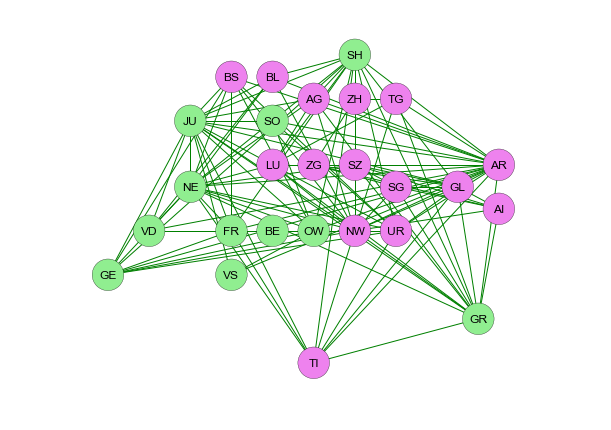

Modularity score: 0.20535272932702486


In [79]:
partition = community.best_partition(G)

for i in set(partition.values()):
    print ("Community", i)
    members = list_nodes = [nodes for nodes in partition.keys() if partition[nodes] == i]
    print (members)

colors = {0 : 'violet', 1: 'lightgreen', 2: 'orange', 3 : 'royalblue'}
cols = []
for i in range(len(values)):
    cols.append(colors[values[i]])
values = [partition.get(node) for node in G.nodes()]
nx.draw(G, pos,cmap = plt.get_cmap('brg'), node_color = cols, node_size=1000, with_labels=True,edge_color='green')
plt.show()

print ("Modularity score:", community.modularity(partition, G))

Also in this case the modularity of the graph is not particularly high. Let visualize this difference in terms of the histograms:

In [82]:
agg = df[['Time','LivingCanton']]
communities = agg.LivingCanton.apply(lambda x: partition[x])
agg['community']=communities
agg = agg.rename(columns={'Time':'mean time [minutes]','LivingCanton':'Canton'})
p = Histogram(agg, values='mean time [minutes]', label='community', legend=True,
            color='community',title='Community-based histograms (male 42 km)')
p.title.align = "center"
p.title.text_font_size = "18px"
p.xaxis[0].axis_label = 'Canton'
p.yaxis[0].axis_label = 'mean time [minutes]'
p.xaxis[0].axis_label_text_font_size = '16px'
p.yaxis[0].axis_label_text_font_size = '16px'

show(p)

C:\Users\Utente\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [83]:
zone = []
for c in cantons:
    zone.append(partition[c])
geopartition = pd.DataFrame({'canton' : cantons, 'zone' : zone})
geopartition.head()

,canton,zone
0,VS,0
1,BE,0
2,FR,0
3,JU,0
4,AG,1


In [85]:
map_geopart = folium.Map(location=[46.8, 8],zoom_start=8)
state_geo = r'ch-cantons.topojson.json'
map_geopart.choropleth(geo_path=state_geo,key_on='feature.id',topojson='objects.cantons',data=geopartition,
                   columns=['canton','zone'],fill_color='BuPu', fill_opacity=0.7, line_opacity=0.2,
                  legend_name='Geographical zone',
                  threshold_scale=[0,0.5,1])
map_geopart

Also in this case two components emerge from the analysis. Moreover, they resemble quite well the women distribution, apart from the East-Southern region (Tessin and Graubunden Cantons). As before, we apply a macroscopic KS test to validate this splitting:

In [88]:
comm = agg.community.unique()
samples = []
for k in comm:
    samples.append(agg['mean time [minutes]'][agg.community==k])

In [89]:
p_values = {}
for i in range(len(comm)):
    for j in range(i,len(comm)):
        p_values[(i,j)]=stats.ks_2samp(samples[i],samples[j])[1]

In [90]:
P_VALUES = pd.DataFrame()
for j in range(len(comm)):
    col = []
    for i in range(0,j):
        p = p_values[(i,j)]
        col.append(p)
    col.append(1.0)
    for i in range(j+1,len(comm)):
        p = p_values[(j,i)]
        col.append(p)
    col = pd.Series(data=col,index=comm)
    P_VALUES[comm[j]]=col
P_VALUES

,0,1
0,1.000000e+00,1.972400e-176
1,1.972400e-176,1.000000e+00


Also in this case the p-value is numerically 0.

## Sensitivity analysis

As done with the female marathon, we perform a brief sensitivity analysis with respect to the threshold $\alpha$.

In [94]:
samples = []
for k in cantons:
    samples.append(df.Time[df.LivingCanton==k])

In [95]:
p_values = {}
for i in range(len(cantons)):
    for j in range(i,len(cantons)):
        p_values[(i,j)]=stats.ks_2samp(samples[i],samples[j])[1]

In [96]:
# generate a list of dataframes, each one associated to a certain statistical threshold
alpha = [0.1,0.025,0.01]
P_VALUES = []
for k in range(len(alpha)):
    pv = pd.DataFrame()
    for j in range(len(cantons)):
        col = []
        for i in range(0,j):
            p = p_values[(i,j)]
            col.append(p)
        col.append(1.0)
        for i in range(j+1,len(cantons)):
            p = p_values[(j,i)]
            col.append(p)
        col = pd.Series(data=col,index=cantons)
        pv[cantons[j]]=col
    P_VALUES.append(pv)

In [97]:
for k in range(len(alpha)):
    for q in P_VALUES[k].columns:
        P_VALUES[k][q] = P_VALUES[k][q].apply(lambda y: (y<alpha[k]))

In [98]:
GRAPHS = []
for k in range(len(alpha)):
    G = nx.Graph()
    cantons = list(cantons)
    for i in range(len(cantons)):
        G.add_node(cantons[i],pos=positions[cantons[i]])
    for i in range(len(cantons)):
        for j in range(i+1,len(cantons)):
            if P_VALUES[k][cantons[i]].loc[cantons[j]]==False:
                G.add_edge(cantons[i],cantons[j])
    GRAPHS.append(G)

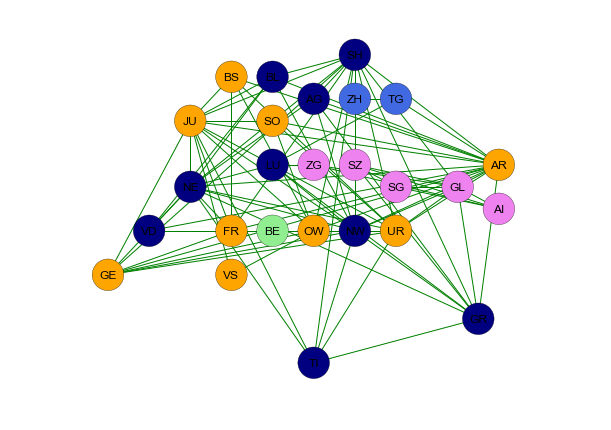

alpha: 0.1
Modularity score: 0.26144185484844823


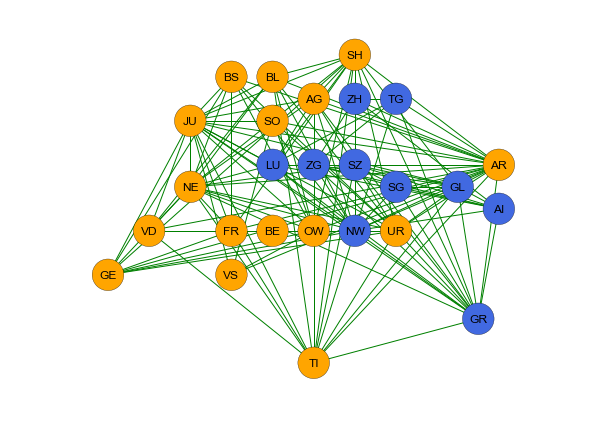

alpha: 0.025
Modularity score: 0.20979591836734696


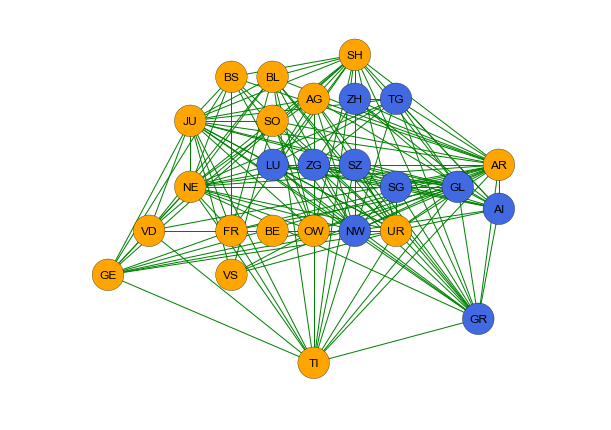

alpha: 0.01
Modularity score: 0.16164142779881016


In [100]:
for k in range(len(alpha)):
    partition = community.best_partition(GRAPHS[k])

    for i in set(partition.values()):
        members = list_nodes = [nodes for nodes in partition.keys() if partition[nodes] == i]

    values = [partition.get(node) for node in GRAPHS[k].nodes()]
    colors = {0 : 'orange', 1 : 'royalblue', 2 : 'violet', 3 : 'lightgreen', 4: 'navy'}
    cols = []
    for i in range(len(values)):
        cols.append(colors[values[i]])
    nx.draw(GRAPHS[k], pos,cmap = plt.get_cmap('brg'), node_color = cols, node_size=1000, with_labels=True,edge_color='green')
    plt.show()
    print('alpha:',alpha[k])
    print ("Modularity score:", community.modularity(partition, GRAPHS[k]))

In this case the variations of the threshold seem more determinant above the standard $5\%$ (observe indeed the formation of 5 communities), but below $5\%$ we retrieve regularity and coherence with the computed geographical pattern.